# OOD Detection Pipeline

## 1. Load data to obtain hidden representations.

### Datasets

In [1]:
from constants.data_constants import JORDAN_DATASET_FILEPATH, MAESTRO_DATASET_FILEPATH
from data.jordan_dataset import JordanDataset
from data.maestro_dataset import MaestroDataset


print("Loading Jordan dataset - train")
id_train_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="train",
    name="id_train_dataset"
)
print(f"Obtained {len(id_train_dataset)} training examples from Jordan dataset - train")

print("Loading Jordan dataset - test")
id_test_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="validation",
    name="id_test_dataset",
    num_samples=80
)
print(f"Obtained {len(id_test_dataset)} testing examples from Jordan dataset - test")

print("Loading Maestro dataset - test")
ood_dataset = MaestroDataset(
    data_dir=MAESTRO_DATASET_FILEPATH,
    split="test",
    name="maestro_test_dataset",
    num_samples=80
)
print(f"Obtained {len(ood_dataset)} testing examples from Maestro dataset - test")

/data/scratch/joeltjy1/conda_envs/ood-detection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Jordan dataset - train
Obtained 4550 training examples from Jordan dataset - train
Loading Jordan dataset - test
Obtained 80 testing examples from Jordan dataset - test
Loading Maestro dataset - test
Obtained 80 testing examples from Maestro dataset - test


### DataLoaders

In [2]:
from torch.utils.data import DataLoader
from utils.data_loading import collate_fn

batch_size = 8

id_train_dataloader = DataLoader(id_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
id_test_dataloader = DataLoader(id_test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
ood_dataloader = DataLoader(ood_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


### Model

In [3]:
from constants.model_constants import DEVICE, JORDAN_MODEL_NAME
import torch
from transformers import AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained(
    JORDAN_MODEL_NAME,
    dtype=torch.float32,
).to(DEVICE)

# 2. OOD Detector

Refer to [OOD detection docs](../../docs/ood_detection.md) for more information about this.

In [4]:
from main.transformation_functions import extract_layer_with_mean_std_pooling
from main.transformations import Transformations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from main.scoring_functions import mahalanobis_distance

transformations = Transformations(
    [
        extract_layer_with_mean_std_pooling(model, [12]),
        PCA(n_components=10),
        StandardScaler(),
    ]
)
scoring_function = mahalanobis_distance

## Create OOD detector
from transformations and scoring function

In [5]:
from main.ood_detector import OODDetector

ood_detector = OODDetector(
    embedding_function=transformations,
    scoring_function=scoring_function,
    id_train_data=id_train_dataloader,
)

We can evaluate the detector!

```threshold = 0.7``` with ```threshold_type = "percentile"``` means that the score threshold is set to be the 70th percentile of all the scores (ID test + OOD test combined).

In [6]:
confusion_matrix, true_positive_rate, false_positive_rate = ood_detector.evaluate(
    id_test_dataloader,
    ood_dataloader,
    threshold=0.7,
    threshold_type="percentile",
)
print("Confusion matrix:", confusion_matrix)
print("True positive rate:", true_positive_rate)
print("False positive rate:", false_positive_rate)


Confusion matrix: tensor([[41, 39],
        [ 8, 76]])
True positive rate: tensor(0.5125)
False positive rate: tensor(0.0952)


We can plot the ROC curve and get AUROC!

AUROC will appear as ```main/auroc.png```

In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

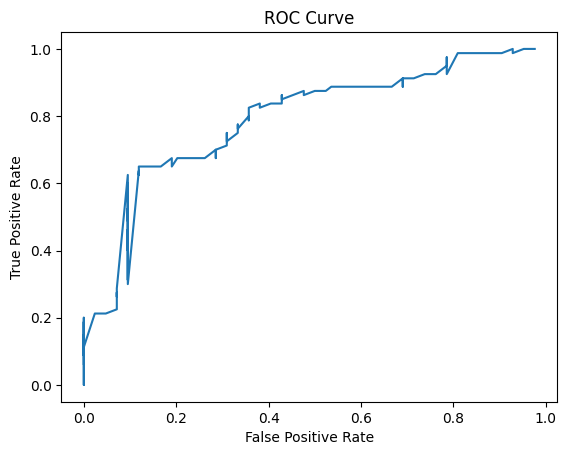

In [8]:
from eval.auroc import get_auroc

auroc = get_auroc(
    ood_detector,
    id_test_dataloader,
    ood_dataloader,
)

In [9]:
print("AUROC:", auroc)



AUROC: 0.7664434313774109


## Visualization

In [10]:
from eval.graph_viz import get_graph_visualization

fig = get_graph_visualization(
    ood_detector,
    id_test_dataloader,
    ood_dataloader,
)

Hear ID input samples and outputs:

In [11]:
id_input_index = 1

id_input_sample = id_test_dataloader.dataset[id_input_index]
print(id_input_sample["input_ids"][:50])





tensor([55026,     0, 10050, 11042,    40, 10035, 11057,    88, 10025, 11062,
          107, 10164, 11054,   129, 10096, 11057,   149, 10012, 11062,   161,
        10020, 11064,   168, 10059, 11066,   176, 10045, 11062,   178, 10102,
        11074,   272, 10029, 11069,   274, 10014, 11057,   374, 10000, 27512,
          390, 10075, 11072,   393, 10045, 11057,   393, 10051, 11069,   393])
